In [2]:
# import  os
# #set visibile cuda
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from corner import corner

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
import emcee
device='cuda'

In [2]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import anneal_dsm_score_estimation
from tools.score_net import score_model_cond,score_model
from tools.sampling import annealed_langevin_dynamic_sampler

In [6]:
from scipy.special import gamma,digamma

$$
\begin{aligned}f(x\mid\alpha,\beta)&=\frac1{\Gamma(\alpha)\beta^\alpha}x^{\alpha-1}e^{-x/\beta}\end{aligned}
$$
$$
\left.\frac\partial{\partial\theta}\log f(X\mid\theta)=\left(\begin{array}{c}\frac\partial{\partial\alpha}\log f\\\frac\partial{\partial\beta}\log f\end{array}\right.\right)=\left(\begin{array}{c}-\psi(\alpha)-\log\beta+\log X\\-\frac\alpha\beta+\frac X{\beta^2}\end{array}\right)
$$
$$
\left.I(\theta)=-E\left(\begin{array}{cc}\frac{\partial^2l}{\partial\alpha^2}&\frac{\partial^2l}{\partial\alpha\partial\beta}\\\frac{\partial^2l}{\partial\beta\partial\alpha}&\frac{\partial^2l}{\partial\beta^2}\end{array}\right.\right)=-E\left(\begin{array}{cc}-\psi^{\prime}(\alpha)&\frac{-1}\beta\\\frac{-1}\beta&\frac\alpha{\beta^2}-\frac{2X}{\beta^3}\end{array}\right)=\left(\begin{array}{cc}\psi^{\prime}(\alpha)&\frac1\beta\\\frac1\beta&\frac\alpha{\beta^2}\end{array}\right)
$$
$$
\left.I(\theta)^{-1}=\frac{\beta^2}{\alpha\psi^{\prime}(\alpha)-1}\left(\begin{array}{cc}\frac\alpha{\beta^2}&-\frac1\beta\\-\frac1\beta&\psi^{\prime}(\alpha)\end{array}\right.\right)=\frac1{\alpha\psi^{\prime}(\alpha)-1}\left(\begin{array}{cc}\alpha&-\beta\\-\beta&\beta^2\psi^{\prime}(\alpha)\end{array}\right)
$$

In [ ]:
def two_param_gamma(alpha,beta):
    pass

$$
\begin{gathered}
\begin{aligned}f(x\mid\mu,\xi)=\frac{1}{\sqrt{2\pi\xi}}e^{-(x-\mu)^2/(2\xi)}.\end{aligned} \\
\text{Note that} \\
l=\log f=-\frac12\log(2\pi\xi)-\frac{(x-\mu)^2}{2\xi} \\
\text{and} \\
\left.\frac\partial{\partial\theta}\log f(X\mid\theta)=\left(\begin{array}{c}\frac\partial{\partial\mu}\log f\\\frac\partial{\partial\xi}\log f\end{array}\right.\right)=\left(\begin{array}{c}\frac{x-\mu}\xi\\-\frac1{2\xi}+\frac{(x-\mu)^2}{2\xi^2}\end{array}\right) \\
\text{and} \\
\left.I(\theta)=-E\left(\begin{array}{cc}\frac{\partial^2l}{\partial\mu^2}&\frac{\partial^2l}{\partial\mu\partial\xi}\\\frac{\partial^2l}{\partial\xi\partial\mu}&\frac{\partial^2l}{\partial\xi^2}\end{array}\right.\right)=-E\left(\begin{array}{cc}\frac{-1}{\xi}&\frac{-(X-\mu)}{\xi^2}\\\frac{-(X-\mu)}{\xi^2}&\frac{1}{2\xi^2}-\frac{(X-\mu)^2}{\xi^3}\end{array}\right)=\left(\begin{array}{cc}\frac{1}{\xi}&0\\0&\frac{1}{2\xi^2}\end{array}\right) 
\end{gathered}
$$

In [3]:
def gaussian_simulator(thetas):
    mu, sigma= thetas[:,0],thetas[:,1]
    return np.random.normal(mu,sigma)[:,np.newaxis] 

# def guassian_log_likelihood(thetas, x):
#     mu, sigma= thetas[:,0],thetas[:,1]
#     return -0.5*np.log(2*np.pi*sigma**2)-0.5*(x-mu)**2/sigma**2

def gaussian_fisher_score(thetas, x):
    mu, sigma= thetas[:,:1],thetas[:,1:]
    dlogL_dmu=(x-mu)/sigma**2
    dlogL_dsigma=(x-mu)**2/(2*sigma**4)-1/(2*sigma**2)

    fs=np.concatenate([dlogL_dmu,dlogL_dsigma],axis=1)
    return fs

def gaussian_fisher_matrix(thetas):
    mu, sigma= thetas[:,0],thetas[:,1]
    fm = np.zeros((thetas.shape[0],2,2))
    fm[:,0,0]=1/sigma**2
    fm[:,1,1]=1/(2*sigma**4)
    return fm

In [4]:
mu_prior_params = [0,0.2] #mean and std of mu prior
sigma_prior_params = [1,0.2] #mean and std of sigma prior

def prior_thetas(n_samples):
    mu = np.random.normal(mu_prior_params[0],mu_prior_params[1],n_samples)
    sigma = np.random.normal(sigma_prior_params[0],sigma_prior_params[1],n_samples)
    return np.column_stack([mu,sigma])

#score for guassian with respect to x
def gaussian_sample_score(thetas_prior_param, thetas):
    score= ((thetas_prior_param[:,0]-thetas)/thetas_prior_param[:,1]**2)
    return score

In [5]:
thetas= prior_thetas(100000)
samples = gaussian_simulator(thetas)

#generate one sample for posterior test
test_theta = np.array([[0.2,0.12]])
obs = gaussian_simulator(test_theta)   

In [6]:
#use emcee to sample from the posterior

def guassian_log_likelihood(thetas, x):
    mu, sigma= thetas[0],thetas[1]
    return -0.5*np.log(2*np.pi*sigma**2)-0.5*(x-mu)**2/sigma**2

def prior_log_prob(thetas):
    mu, sigma= thetas[0],thetas[1]
    return guassian_log_likelihood(mu_prior_params,mu)+guassian_log_likelihood(sigma_prior_params,sigma)

def log_posterior(thetas, x):
    return guassian_log_likelihood(thetas, x) + prior_log_prob(thetas)

ndim, nwalkers = 2, 10
nsteps, nburn = 10000, 100   
pos = np.array([test_theta[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[obs])

sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 10000/10000 [00:05<00:00, 1977.59it/s]


In [7]:
test_theta = np.array([[0.0,0.10]])+ 3*np.random.randn(2)*np.array([0.1,0.02])
obs = gaussian_simulator(test_theta)

In [8]:
test_theta,prior_log_prob(test_theta[0]),guassian_log_likelihood(test_theta[0],obs)

(array([[-0.04101581,  0.13675536]]),
 -7.954921218596121,
 array([[0.98284557]]))

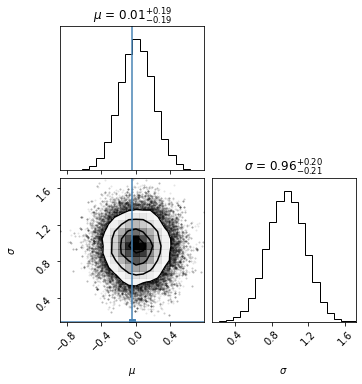

In [9]:
ref_pos= sampler.chain[:,nburn:,:].reshape(-1,ndim)
corner(ref_pos,labels=[r'$\mu$',r'$\sigma$'],show_titles=True,truths=test_theta[0]);

### Posterior Score Fitting

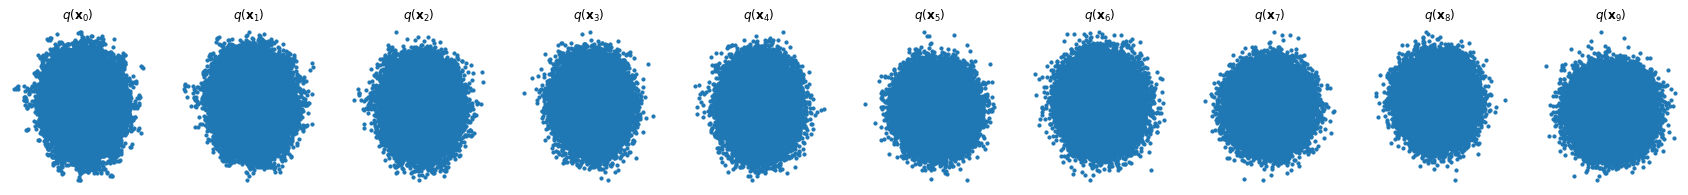

In [10]:
ns=noise_scheduler(1e-5,1e-1,10,schedule='sigmoid',var_norm=False)
ns.visualize_noise(torch.tensor(ref_pos))

In [11]:
ns.sigmas

tensor([0.0160, 0.0307, 0.0588, 0.1092, 0.1842, 0.2571, 0.2968, 0.3107, 0.3148,
        0.3158])

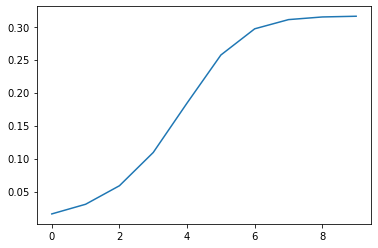

In [12]:
ns.plot_sigmas()

In [13]:
pos_model = score_model_cond(100,x_dim=2,x_cond_dim=1).to(device)
optimizer = optim.Adam(pos_model.parameters(), lr=1e-3)

In [14]:
epochs=1000
# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
batch_size=1000
for epoch in range(epochs):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas[indices]
        batch_x_cond = dataset[indices]

        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)

        loss = anneal_dsm_score_estimation(pos_model, batch_x, labels, ns,samples_cond=batch_x_cond)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if ((epoch % 100) == 0):
        print(loss.item())

0.582371175289154
0.5770711898803711
0.5788822174072266
0.5718419551849365
0.5435981154441833
0.5945201516151428
0.595950722694397
0.5935248136520386
0.5891886949539185
0.5672511458396912


In [15]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=1000 , 
                                            score_fn=pos_model, 
                                            device=device, 
                                            eps = 1e-5)

In [16]:
init_point=torch.tensor(prior_thetas(10000)).float().to(device)

sample_cond=torch.tensor(np.repeat(obs,10000,axis=0),dtype=torch.float32).to(device)

dynamic=sampler.sample(init_point,sample_cond=sample_cond)

# fig=corner(dynamic[-1].cpu().numpy());
# corner(ref_pos,fig=fig,color='red');

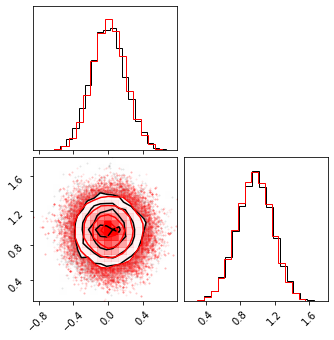

In [17]:
fig=corner(dynamic[-1].cpu().numpy(),hist_kwargs={'density':True});
corner(ref_pos,fig=fig,color='red',hist_kwargs={'density':True});

### Prior Score fitting

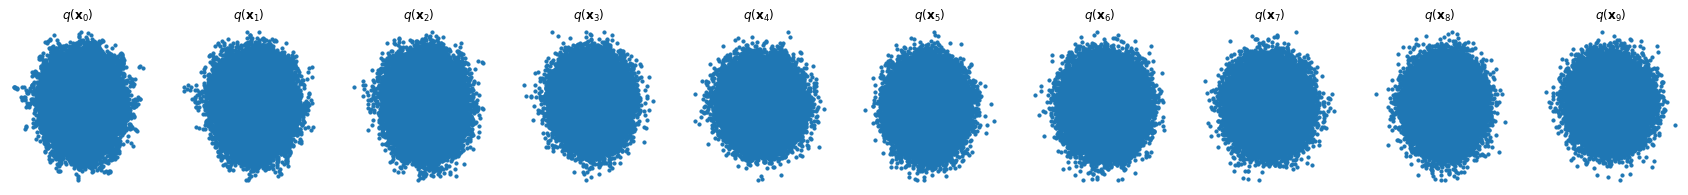

In [21]:
ns=noise_scheduler(1e-5,1e-1,10,schedule='sigmoid',var_norm=False)
ns.visualize_noise(torch.tensor(ref_pos))

In [22]:
# Our approximation model
prior_model = score_model(ns.n_steps,2).to(device)
# Create ADAM optimizer over our model
optimizer = optim.Adam(prior_model.parameters(), lr=1e-3)

In [23]:
epochs=1000

thetas=torch.tensor(thetas).float().to(device)
batch_size=1000

for epoch in range(epochs):
    permutation = torch.randperm(thetas.size()[0])
    for i in range(0, thetas.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch = thetas[indices]

        labels = torch.randint(0, ns.n_steps, (batch.shape[0],)).to(device)
        loss = anneal_dsm_score_estimation(prior_model, batch, labels, ns)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if ((epoch % 100) == 0):
        print(loss.item())

/tmp/ipykernel_2057789/566015087.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


0.649554431438446
0.560306191444397
0.6066187024116516
0.588936984539032
0.5760530233383179
0.5757467746734619
0.5686067342758179
0.5696752071380615
0.5667272210121155
0.557445228099823


In [24]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=1000 , 
                                            score_fn=prior_model, 
                                            device=device, 
                                            eps = 1e-5)

init_point=torch.randn(10000,2).to(device)
dynamic=sampler.sample(init_point)

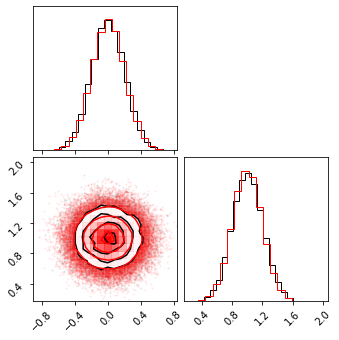

In [25]:
fig=corner(dynamic[-1].cpu().numpy(),hist_kwargs={'density':True});
corner(thetas.detach().cpu().numpy(),fig=fig,color='red',hist_kwargs={'density':True});

In [75]:
def gaussian_sample_score(thetas_prior_param, thetas):
    score= ((thetas_prior_param[:,0]-thetas)/thetas_prior_param[:,1]**2)
    return score

In [80]:
gaussian_sample_score(thetas_prior_param=np.array([mu_prior_params,sigma_prior_params]), thetas=np.array([0,1.1]))

array([ 0. , -2.5])

In [83]:
labels = torch.ones(1).long().to(device)*0
prior_model(torch.tensor([[0,1]]).float().to(device),labels)

tensor([[ 0.1511, -0.1412]], device='cuda:0', grad_fn=<AddmmBackward0>)

(0.4, 1.6)

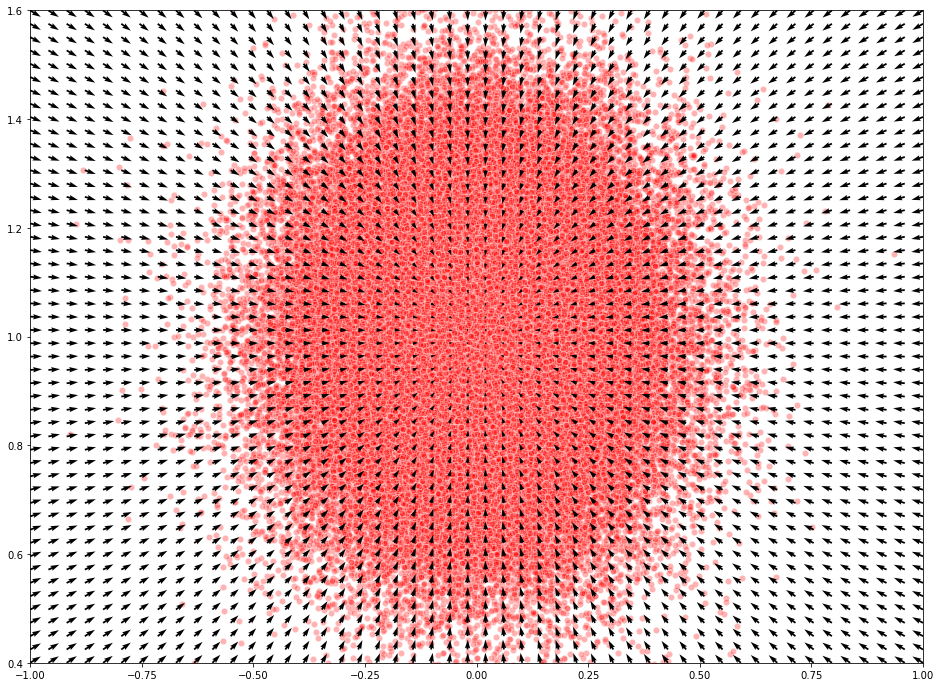

In [87]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(0.4, 1.6, 50)), axis=-1).reshape(-1, 2)
true_scores = gaussian_sample_score(thetas_prior_param=np.array([mu_prior_params,sigma_prior_params]), thetas=xx)
scores_norm = np.linalg.norm(true_scores, axis=-1, ord=2, keepdims=True)
scores_log1p = true_scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(0.4, 1.6)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

(0.4, 1.6)

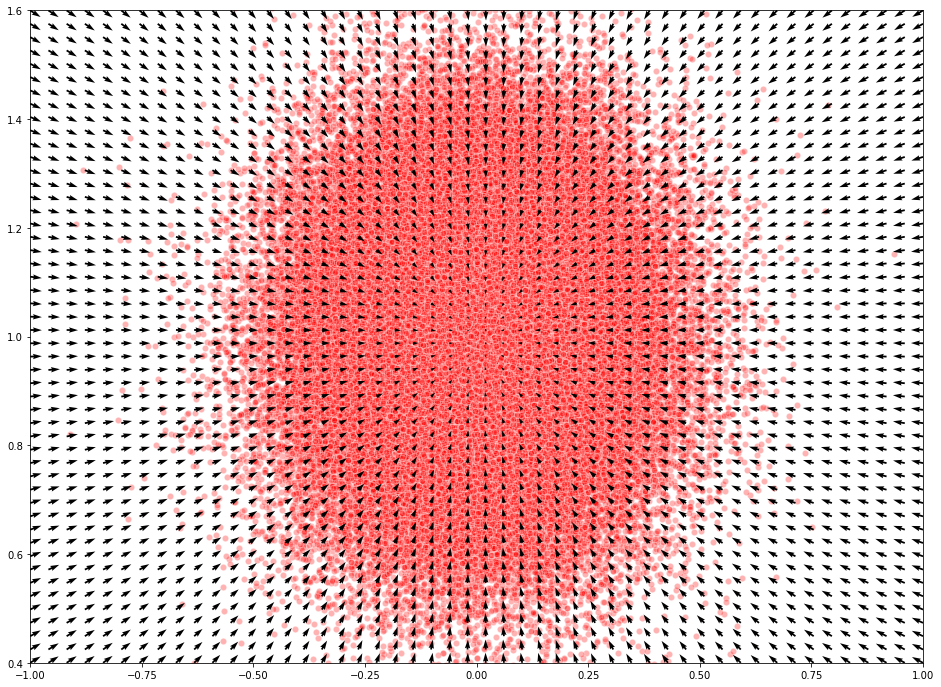

In [88]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(0.4, 1.6, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
labels = torch.ones(xx.shape[0]).long().to(device)*0
scores = prior_model(torch.tensor(xx).float().to(device), labels).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(0.4, 1.6)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

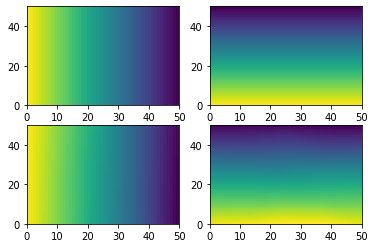

In [89]:
plt.subplot(2,2,1)
plt.pcolor(true_scores[:,0].reshape(50,50))

plt.subplot(2,2,2)
plt.pcolor(true_scores[:,1].reshape(50,50))

plt.subplot(2,2,3)
plt.pcolor(scores[:,0].reshape(50,50))

plt.subplot(2,2,4)
plt.pcolor(scores[:,1].reshape(50,50))

Text(0.5, 1.0, 'relative error of score 2')

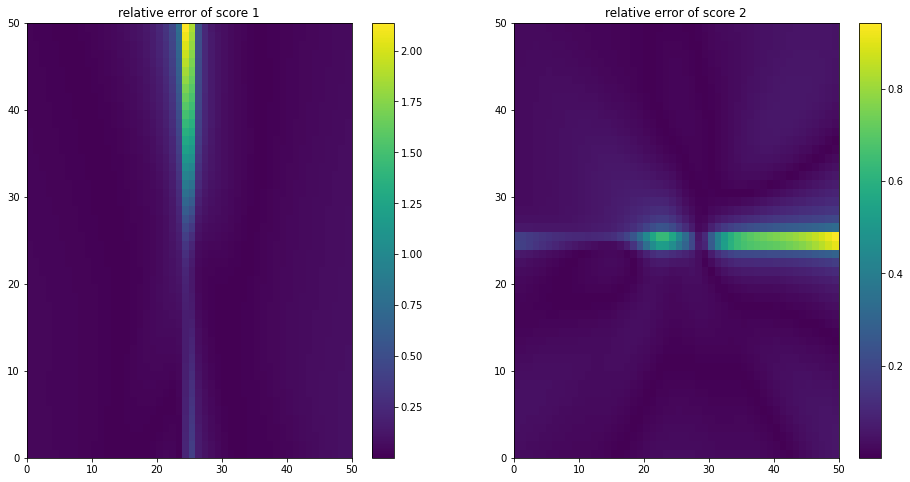

In [90]:
#relative errors of scores

r_error=np.abs((scores-true_scores)/true_scores)
#pcolor
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.pcolor(r_error[:,0].reshape(50,50))
plt.colorbar()
plt.title('relative error of score 1')

plt.subplot(1,2,2)
plt.pcolor(r_error[:,1].reshape(50,50))
plt.colorbar()
plt.title('relative error of score 2')

### Fisher Information Estimation

In [46]:
def fisher_score(x,theta):
    labels=torch.ones(x.shape[0]).long().to(device)*0
    
    with torch.no_grad():
        fs=pos_model(theta,x,labels)-prior_model(theta,labels)

    return fs

def estimate_fisher_matrix(thetas):

    true_thetas = torch.tensor(np.repeat(test_theta, 10000, axis=0)).float()
    true_thetas_samples = gaussian_simulator(true_thetas)


    #calcuate the fisher score at every sample in true_thetas_samples
    temp_fs=fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device)).cpu().numpy()
    
    #estimate fisher matrix through averaging
    estimate_fisher_matrix=(temp_fs[:,:,None]*temp_fs[:,None,:]).mean(axis=0)

    return estimate_fisher_matrix

(0.4, 1.6)

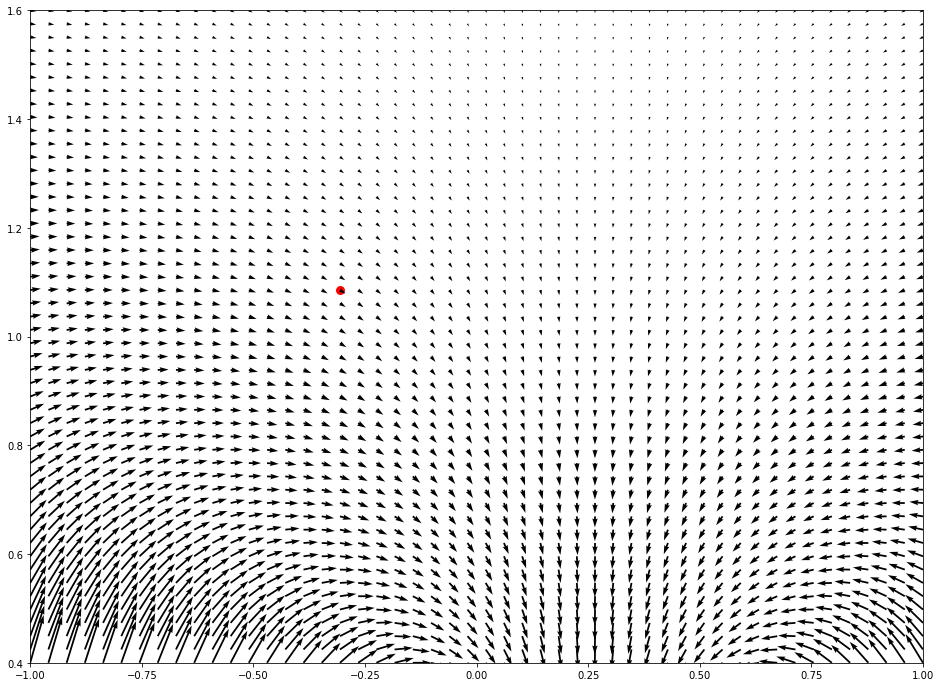

In [44]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(0.4, 1.6, 50)), axis=-1).reshape(-1, 2)
idx = np.random.randint(2500)
obs = np.repeat(gaussian_simulator(xx[idx][None,:]),xx.shape[0],axis=0)

true_fisher_score=gaussian_fisher_score(xx,obs)

scores_norm = np.linalg.norm(true_fisher_score, axis=-1, ord=2, keepdims=True)
scores_log1p = true_fisher_score / (scores_norm + 1e-9) * np.log1p(scores_norm)

# Perform the plots
plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.scatter(*xx[idx], color='red', edgecolor='white', s=100)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
# plt.quiver(*xx.T, *true_fisher_score.T, width=0.002, color='black')

plt.xlim(-1, 1)
plt.ylim(0.4, 1.6)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

(0.4, 1.6)

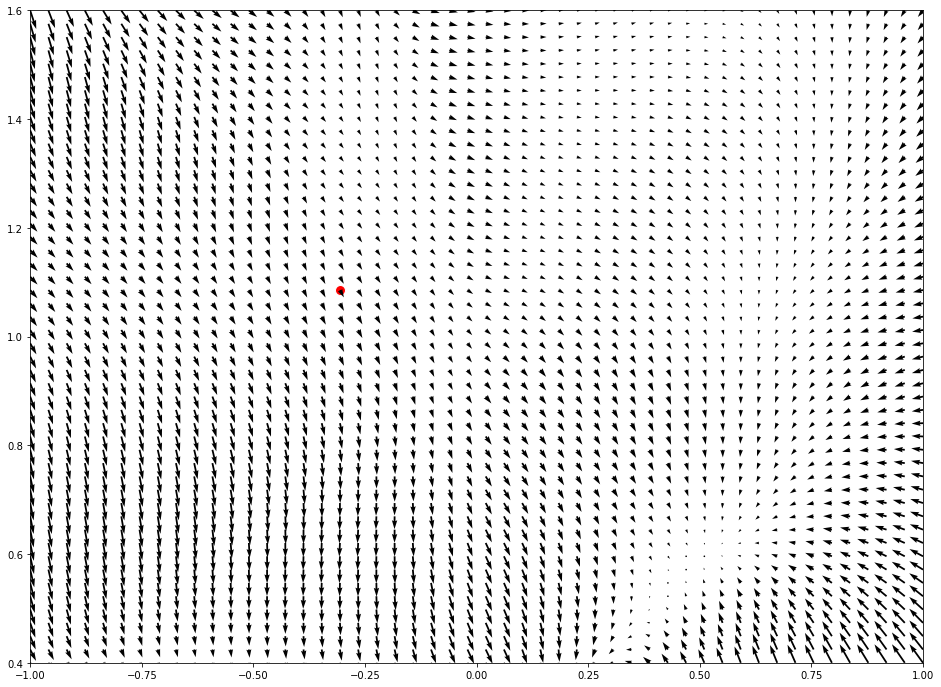

In [45]:
# xx = np.stack(np.meshgrid(np.linspace(-3, 3, 50), np.linspace(0.04, 0.16, 50)), axis=-1).reshape(-1, 2)
# obs = gaussian_simulator(xx)  

score=fisher_score(torch.tensor(obs).float().to(device),torch.tensor(xx).float().to(device)).cpu().numpy()
scores_norm = np.linalg.norm(score, axis=-1, ord=2, keepdims=True)
scores_log1p = score / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.scatter(*xx[idx], color='red', edgecolor='white', s=100)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(0.4, 1.6)


# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [48]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(0.4, 1.6, 50)), axis=-1).reshape(-1, 2)
fm_estimate_all=np.zeros((2500,2,2))
for i in range(2500):
    fm_estimate_all[i]=estimate_fisher_matrix(xx[i][None,:])

fm_all=gaussian_fisher_matrix(xx)

/tmp/ipykernel_2057789/50325022.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_fs=fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device)).cpu().numpy()


Text(0.5, 1.0, 'Fisher matrix 2,2')

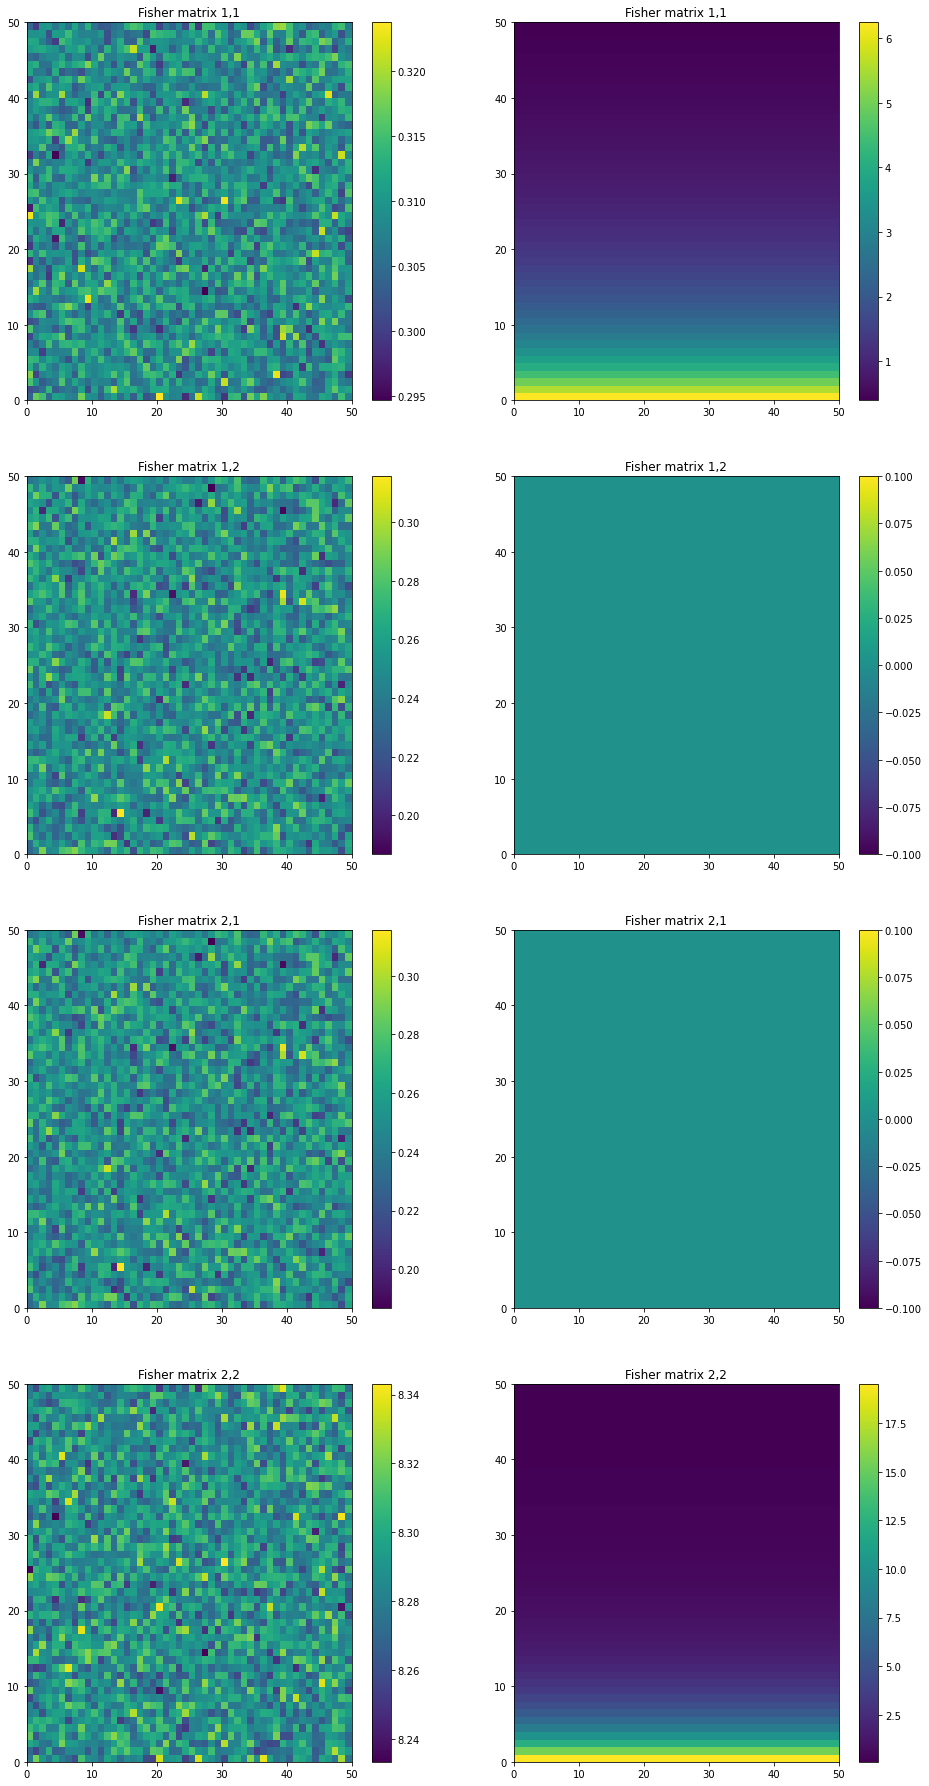

In [49]:


plt.figure(figsize=(16,32))
plt.subplot(4,2,1)
plt.pcolor(fm_estimate_all[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,2,2)
plt.pcolor(fm_all[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,2,3)
plt.pcolor(fm_estimate_all[:,0,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,2')

plt.subplot(4,2,4)
plt.pcolor(fm_all[:,0,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,2')

plt.subplot(4,2,5)
plt.pcolor(fm_estimate_all[:,1,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,1')

plt.subplot(4,2,6)
plt.pcolor(fm_all[:,1,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,1')

plt.subplot(4,2,7)
plt.pcolor(fm_estimate_all[:,1,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,2')

plt.subplot(4,2,8)
plt.pcolor(fm_all[:,1,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,2')



In [37]:
labels=torch.ones(xx.shape[0]).long().to(device)*0

with torch.no_grad():
    poss=pos_model(torch.tensor(xx).float().to(device),torch.tensor(obs).float().to(device),labels)
    prrs=prior_model(torch.tensor(xx).float().to(device),labels)


In [116]:
#generate one sample
test_theta = np.array([[1,0.12]])
obs = gaussian_simulator(test_theta)   

In [117]:
true_thetas = torch.tensor(np.repeat(test_theta, 10000, axis=0)).float()
true_thetas_samples = gaussian_simulator(true_thetas)

In [118]:
true_fisher_score=gaussian_fisher_score(test_theta,obs)
true_fisher_matrix=gaussian_fisher_matrix(test_theta)

In [119]:
#calcuate the fisher score at (test_theta,obs)
estimate_fs=fisher_score(torch.tensor(obs).float().to(device),torch.tensor(test_theta).float().to(device)).cpu().numpy()

#calcuate the fisher score at every sample in true_thetas_samples
temp_fs=fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device)).cpu().numpy()
#estimate fisher matrix through averaging
estimate_fisher_matrix=(temp_fs[:,:,None]*temp_fs[:,None,:]).mean(axis=0)

/tmp/ipykernel_1912814/1783820956.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_fs=fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device)).cpu().numpy()


In [120]:
true_fisher_score,estimate_fs

(array([[[  6.90867052, -10.85735802]]]),
 array([[ 8.59284  , -2.0235386]], dtype=float32))

In [121]:
true_fisher_matrix,estimate_fisher_matrix

(array([[[  69.44444444,    0.        ],
         [   0.        , 2411.2654321 ]]]),
 array([[87.231316,  4.420543],
        [ 4.420543, 57.99625 ]], dtype=float32))

### Direct likelihood score estimation

In [ ]:
def likelihood_dsm_score_estimation(likelihood_score_model,prior_score_model, thetas,x, ts, noise_scheduler, anneal_power=2.):

    perturbed_samples,used_sigmas = noise_scheduler.forward_sample(thetas, ts)
    
    with torch.no_grad():   
        target = - 1 / (used_sigmas ** 2) * (perturbed_samples - thetas)-prior_score_model(thetas,ts)

    scores = likelihood_score_model(perturbed_samples, x, ts)

    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * \
        used_sigmas.squeeze() ** anneal_power
    return loss.mean(dim=0)

In [ ]:
likelihood_model = score_model_cond(100,x_dim=2,x_cond_dim=1).to(device)
optimizer = optim.Adam(likelihood_model.parameters(), lr=1e-3)

In [ ]:
epochs=1000
# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
batch_size=1000
for epoch in range(epochs):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas[indices]
        batch_x_cond = dataset[indices]

        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)

        loss = likelihood_dsm_score_estimation(likelihood_model,prior_model, batch_x,batch_x_cond, labels, ns)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if ((epoch % 100) == 0):
        print(loss.item())

/tmp/ipykernel_2054743/2228780140.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


1.0948994159698486
0.9333117008209229
1.0187053680419922
0.9482498168945312
0.9599635004997253
0.9332762956619263
0.9903060793876648
0.9487655162811279
0.9513296484947205
0.9623374342918396


In [ ]:
#generate one sample
# test_theta = np.array([[0.2,1.4]])
test_theta = prior_thetas(1)
obs = gaussian_simulator(test_theta)   

In [ ]:
true_thetas = torch.tensor(np.repeat(test_theta, 10000, axis=0)).float()
true_thetas_samples = gaussian_simulator(true_thetas)

In [ ]:
true_fisher_score=gaussian_fisher_score(test_theta,obs)
true_fisher_matrix=gaussian_fisher_matrix(test_theta)

In [ ]:
#calcuate the fisher score at (test_theta,obs)
labels=torch.ones(10000).long().to(device)*0
estimate_fs=likelihood_model(torch.tensor(test_theta).float().to(device),torch.tensor(obs).float().to(device),labels[:1]).detach().cpu().numpy()

#calcuate the fisher score at every sample in true_thetas_samples
temp_fs=likelihood_model(torch.tensor(true_thetas).float().to(device),torch.tensor(true_thetas_samples).float().to(device),labels).detach().cpu().numpy()
#estimate fisher matrix through averaging
estimate_fisher_matrix=(temp_fs[:,:,None]*temp_fs[:,None,:]).mean(axis=0)

/tmp/ipykernel_2054743/3876394475.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_fs=likelihood_model(torch.tensor(true_thetas).float().to(device),torch.tensor(true_thetas_samples).float().to(device),labels).detach().cpu().numpy()


In [ ]:
true_fisher_score,estimate_fs

(array([[-0.36785146, -0.42544187]]),
 array([[-0.81873417, -0.56305796]], dtype=float32))

In [ ]:
test_theta

array([[0.0021371 , 1.00697304]])

In [ ]:
true_fisher_matrix,estimate_fisher_matrix

(array([[[0.98619844, 0.        ],
         [0.        , 0.48629368]]]),
 array([[1.4110146 , 0.38606822],
        [0.38606822, 2.462432  ]], dtype=float32))

(0.4, 1.6)

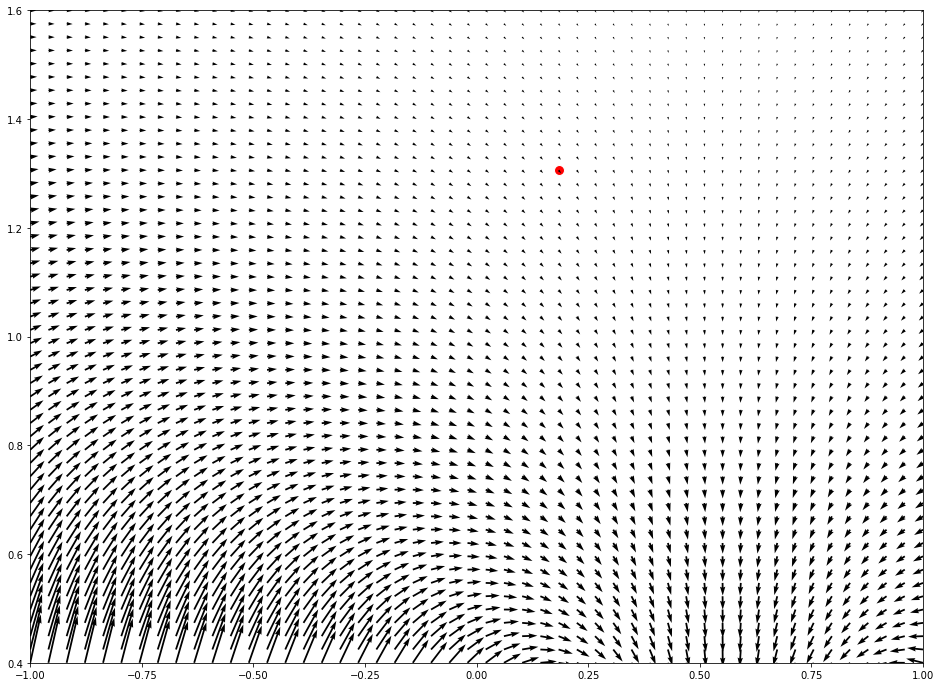

In [ ]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(0.4, 1.6, 50)), axis=-1).reshape(-1, 2)
idx = np.random.randint(2500)
obs = np.repeat(gaussian_simulator(xx[idx][None,:]),xx.shape[0],axis=0)

true_fisher_score=gaussian_fisher_score(xx,obs)

scores_norm = np.linalg.norm(true_fisher_score, axis=-1, ord=2, keepdims=True)
scores_log1p = true_fisher_score / (scores_norm + 1e-9) * np.log1p(scores_norm)

# Perform the plots
plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)

plt.scatter(*xx[idx], color='red', edgecolor='white', s=100)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
# plt.quiver(*xx.T, *true_fisher_score.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(0.4, 1.6)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

(0.4, 1.6)

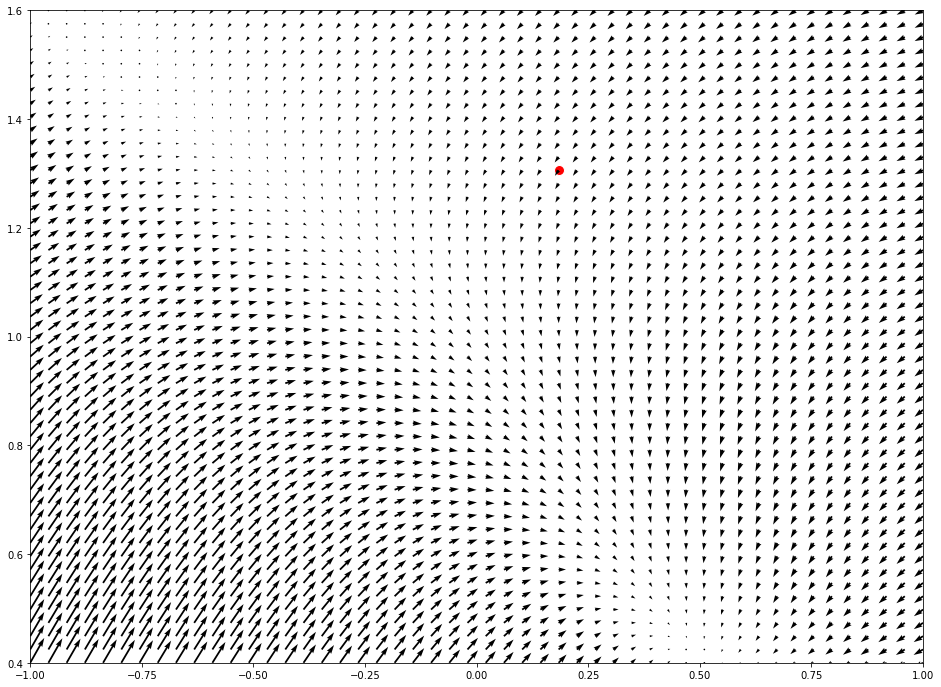

In [ ]:
labels=torch.ones(xx.shape[0]).long().to(device)*0

score_estimate=likelihood_model(torch.tensor(xx).float().to(device),torch.tensor(obs).float().to(device),labels).detach().cpu().numpy()
scores_norm_estimate = np.linalg.norm(score_estimate, axis=-1, ord=2, keepdims=True)
scores_log1p_estimate = score_estimate / (scores_norm_estimate + 1e-9) * np.log1p(scores_norm_estimate)
# Perform the plots
plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.scatter(*xx[idx], color='red', edgecolor='white', s=100)
plt.quiver(*xx.T, *scores_log1p_estimate.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(0.4, 1.6)

In [ ]:
def estimate_fisher_matrix(likelihood_score_model, thetas):

    true_thetas = torch.tensor(np.repeat(thetas, 10000, axis=0)).float()
    true_thetas_samples = gaussian_simulator(true_thetas)

    labels=torch.ones(10000).long().to(device)*0
    #calcuate the fisher score at every sample in true_thetas_samples
    temp_fs=likelihood_score_model(torch.tensor(true_thetas).float().to(device),torch.tensor(true_thetas_samples).float().to(device),labels).detach().cpu().numpy()
    #estimate fisher matrix through averaging
    estimate_fisher_matrix=(temp_fs[:,:,None]*temp_fs[:,None,:]).mean(axis=0)

    return estimate_fisher_matrix

In [ ]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(0.4, 1.6, 50)), axis=-1).reshape(-1, 2)
fm_estimate_all=np.zeros((2500,2,2))
for i in range(2500):
    fm_estimate_all[i]=estimate_fisher_matrix(likelihood_model,xx[i][None,:])

fm_all=gaussian_fisher_matrix(xx)

/tmp/ipykernel_2054743/4117457516.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_fs=likelihood_score_model(torch.tensor(true_thetas).float().to(device),torch.tensor(true_thetas_samples).float().to(device),labels).detach().cpu().numpy()


Text(0.5, 1.0, 'Fisher matrix 2,2')

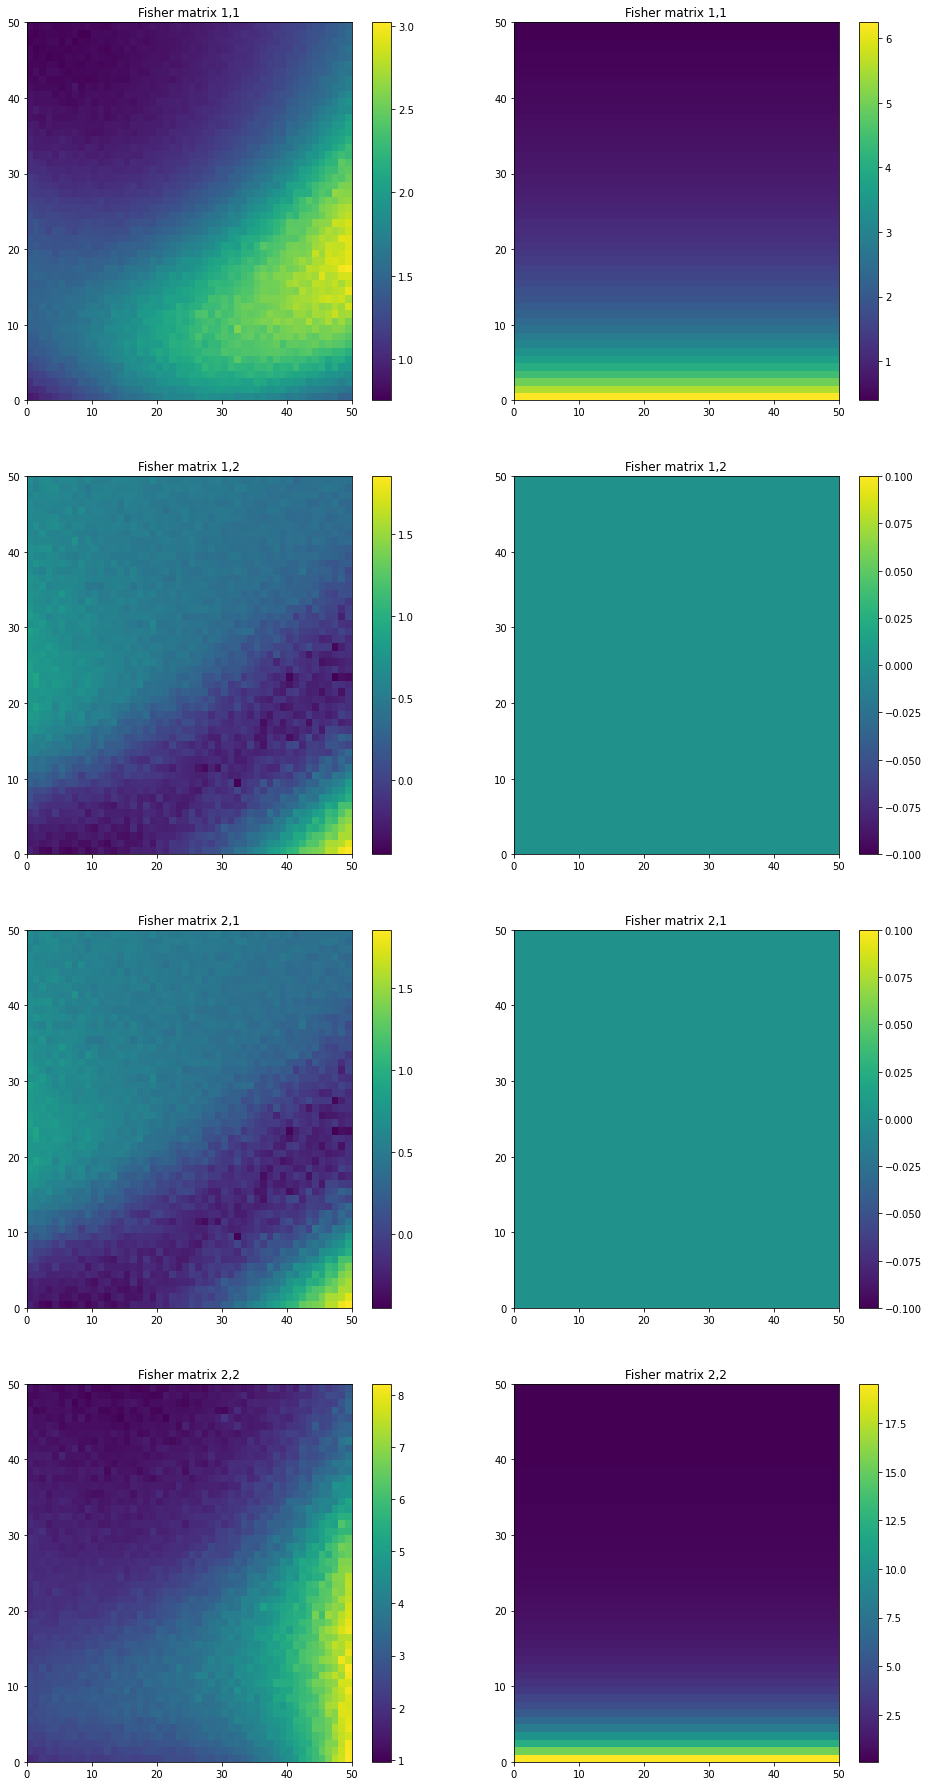

In [ ]:


plt.figure(figsize=(16,32))
plt.subplot(4,2,1)
plt.pcolor(fm_estimate_all[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,2,2)
plt.pcolor(fm_all[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,2,3)
plt.pcolor(fm_estimate_all[:,0,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,2')

plt.subplot(4,2,4)
plt.pcolor(fm_all[:,0,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,2')

plt.subplot(4,2,5)
plt.pcolor(fm_estimate_all[:,1,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,1')

plt.subplot(4,2,6)
plt.pcolor(fm_all[:,1,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,1')

plt.subplot(4,2,7)
plt.pcolor(fm_estimate_all[:,1,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,2')

plt.subplot(4,2,8)
plt.pcolor(fm_all[:,1,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,2')

